In [1]:
#%load_ext tensorboard
#!rm -rf ./logs/
import tensorflow as tf
import datetime
import numpy as np
from skimage.transform import resize
from scipy.ndimage import filters
import scipy.ndimage as nd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

In [2]:
# Wider cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
    

AUTO = tf.data.experimental.AUTOTUNE 

The following cell confugures all the nessesery information for the results file. File definition is found in the AnalyzeResults notebook 

In [4]:
startTime = datetime.datetime.now()
initComment = ' Experimenting with dataset variation. Same input and output, unnormalized '
datasetSize = 0 # Gets filled out after loading
framesSkipped = 5
nx = 640
ny = 360
resolution = (nx, ny)
framesBefore = 2
framesAfter  = 1
baseConvLay  = 32
usedLoss     = ' MSE '
epochs       = 10

chan = 3                                  # Channels per frame, usualy 3 (R, G, B)
frames = framesBefore + framesAfter + 1   # Input frames for the model
outChan = 1                               # Output channels, usualy 3 (R, G, B)
batch_size = 8                            # Batch size for training, lower if you get OOM error
skipFramesBefore = 0                      # Skip input frames before mf for loaded dataset
skipFramesAfter  = 0                      # Skip input frames after mf for loaded dataset

In [5]:
!ls ../../Datasets/

DATASET5thF2b2a       DVRUP_conv3D_float32
DVRUP_1f_2f2b	      DVRUP_conv3D_meanSub
DVRUP_1f_UINT8_82020  DVRUP_conv3D_singleCHoutAndInput_float32
DVRUP_22_05	      DVRUP_conv3D_singleCHoutput_float32
DVRUP_Pre	      DVRUP_mini
DVRUP_Pre_NoNorm      dataset.zip
DVRUP_conv3D	      video


In [6]:
#Full dataset
datasets = ['Skogen', 'Hagen', 'Hytta']
NStartOn = [1,         1,       1     ]
numFiles = [6,         4,       4     ]
#Mini dataset
#datasets = ['Skogen']
#NStartOn = [1]
#numFiles = [6]


valDatasets = ['Skogen']
valNstartOn = [7]
numValFiles = [7]
datasetDir = '../../Datasets/DVRUP_Pre_NoNorm/'
#datasetDir = '../../Datasets/DVRUP_conv3D_singleCHoutAndInput_float32/'
#datasetDir = '../../Datasets/DVRUP_conv3D_singleCHoutput_float32/'
def getInputFiles(d, s, n):
    ds = []
    for i in range(len(d)):
        for j in range(s[i], 1 + n[i]):
            ds.append(datasetDir + d[i] + str(j) + '.tfrec')
    return ds

datasetsToLoad = getInputFiles(datasets, NStartOn, numFiles)
valSetsToLoad = getInputFiles(valDatasets, valNstartOn, numValFiles)
print('training using')
for i in datasetsToLoad:
    print(i)
print('Validating using')
for file in valSetsToLoad:
    print(file)

training using
../../Datasets/DVRUP_Pre_NoNorm/Skogen1.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Skogen2.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Skogen3.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Skogen4.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Skogen5.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Skogen6.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Hagen1.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Hagen2.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Hagen3.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Hagen4.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Hytta1.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Hytta2.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Hytta3.tfrec
../../Datasets/DVRUP_Pre_NoNorm/Hytta4.tfrec
Validating using
../../Datasets/DVRUP_Pre_NoNorm/Skogen7.tfrec


In [7]:
def read_tfrecord(ex):
    features = {
    'X': tf.io.FixedLenFeature([], tf.string),
    'Y': tf.io.FixedLenFeature([], tf.string)
    }
    ex = tf.io.parse_single_example(ex, features)
    #Decoding the TFRecord
    x = tf.io.decode_raw(
        ex['X'], out_type=np.float32, little_endian=True, fixed_length=None, name=None
    )
    y = tf.io.decode_raw(
        ex['Y'], out_type=np.float32, little_endian=True, fixed_length=None, name=None
    )
    x = tf.reshape(x, (360, 640, 4, 1))
    y = tf.reshape(y, (360, 640, 1))
    return x, y

def get_batched_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)

    dataset = dataset.shuffle(128)
    dataset = dataset.batch(batch_size, drop_remainder=True) 
    dataset = dataset.prefetch(AUTO) #

    return dataset

def get_training_dataset():
    return get_batched_dataset(datasetsToLoad)

def get_validation_dataset():
    return get_batched_dataset(valSetsToLoad)

In [8]:
def getSigModel():
    kSize = (3,3,3)
    act = 'relu'
    lact = 'sigmoid'
    loss = 'mse'
    opt = 'RMSprop' #'adam' #'adadelta'
    b_conv = 64
    conv_2 = b_conv * 2
    conv_3 = b_conv * 4
    l_conv = b_conv / 2
    reg = tf.keras.regularizers.l1(10e-10)
    input_layer = tf.keras.layers.Input(shape = (ny, nx, frames, chan))
    #First encoder step
    l1 = tf.keras.layers.Conv3D(b_conv, kernel_size = kSize, padding = 'same', activation = act, strides = (2, 2, 2))(input_layer)
    #Second encoder step
    l2 = tf.keras.layers.Conv3D(conv_2, kernel_size = kSize, padding = 'same', activation = act)(l1)
    l3 = tf.keras.layers.Conv3D(conv_2, kernel_size = kSize, padding = 'same', activation = act)(l2)
    #Third encoder step
    l4 = tf.keras.layers.Conv3D(conv_3, kernel_size = kSize, padding = 'same', activation = act, strides = (2, 2, 2))(l3)
    l5 = tf.keras.layers.Conv3D(conv_3, kernel_size = kSize, padding = 'same', activation = act)(l4)
    l6 = tf.keras.layers.Conv3D(conv_3, kernel_size = kSize, padding = 'same', activation = act)(l5)
    l7 = tf.keras.layers.Conv3D(conv_3, kernel_size = kSize, padding = 'same', activation = act)(l6)
    l8 = tf.keras.layers.Conv3D(conv_3, kernel_size = kSize, padding = 'same', activation = act)(l7)
    #Decoding from third step
    l9 = tf.keras.layers.UpSampling3D((2,2,1))(l8)
    l10 = tf.keras.layers.Conv3D(conv_2, kernel_size = kSize, padding = 'same', activation = act)(l9)
    l11 = tf.keras.layers.Conv3D(b_conv, kernel_size = kSize, padding = 'same', activation = act)(l10)
    l12 = tf.keras.layers.Conv3D(b_conv, kernel_size = kSize, padding = 'same', activation = act)(l11)
    #Decoding from third step
    l13 = tf.keras.layers.UpSampling3D((2,2,1))(l12)
    l14 = tf.keras.layers.Conv3D(l_conv, kernel_size = kSize, padding = 'same', activation = act)(l13)
    
    output_layer = tf.keras.layers.Conv3D(outChan, kSize, padding = 'same', activation = lact)(l14)

    #Autoencoder model
    autoencoder = tf.keras.Model(input_layer, output_layer)
    #autoencoder.summary()
    autoencoder.compile(optimizer = opt, loss = loss, metrics=['acc'])
    return autoencoder

def getIntraConvModel():
    conv3D_args = {
         "kernel_size" : (3,3,3),
         "activation": "tanh",
         "kernel_initializer": "Orthogonal",
         "padding": "same",
         "activity_regularizer" : tf.keras.regularizers.l1(10e-10),
    }
        
    conv2D_args = {
         "kernel_size" : (3,3),
         "activation": "relu",
         "kernel_initializer": "Orthogonal",
         "padding": "same",
         "activity_regularizer" : tf.keras.regularizers.l1(10e-10),
    }
    
    lact = 'sigmoid'
    loss = 'MSE'
    opt = 'adam' #'adam' #'adadelta'
    b_conv = 16
    conv_2 = b_conv * 2
    conv_3 = b_conv * 4
    l_conv = b_conv / 2
    input_layer = tf.keras.layers.Input(shape = (ny, nx, frames, chan))
    #First encoder step
    l1 = tf.keras.layers.Conv3D(b_conv, strides = (2, 2, 1), **conv3D_args)(input_layer)
    #Second encoder step
    l2 = tf.keras.layers.Conv3D(conv_2, **conv3D_args)(l1)
    l3 = tf.keras.layers.Conv3D(conv_2, **conv3D_args)(l2)
    #Third encoder step
    l4 = tf.keras.layers.Conv3D(conv_3, strides = (2, 2, 1), **conv3D_args)(l3)
    
    l5 = tf.keras.layers.Conv3D(conv_3, **conv3D_args)(l4)
    l6 = tf.keras.layers.Conv3D(conv_3, strides = (1, 1, 2), **conv3D_args)(l5)
    l7 = tf.keras.layers.Conv3D(conv_3, strides = (1, 1, 2), **conv3D_args)(l6)
    
    lr = tf.keras.layers.Reshape((90, 160, conv_3))(l7)
    l8 = tf.keras.layers.Conv2D(conv_3, **conv2D_args)(lr)
    #Decoding from third step
    l9 = tf.keras.layers.UpSampling2D((2,2))(l8)
    l10 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l9)
    l11 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l10)
    l12 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l11)
    #Decoding from third step
    l13 = tf.keras.layers.UpSampling2D((2,2))(l12)
    l14 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l13)
    
    output_layer = tf.keras.layers.Conv2D(outChan, (3,3), padding = 'same', activation = lact)(l14)

    #Autoencoder model
    autoencoder = tf.keras.Model(input_layer, output_layer)
    #autoencoder.summary()
    autoencoder.compile(optimizer = opt, loss = loss, metrics=['acc'])
    return autoencoder

def getIntraSingleChModel():
    conv3D_args = {
         "kernel_size" : (3,3,3),
         "activation": "tanh",
         "kernel_initializer": "Orthogonal",
         "padding": "same",
         "activity_regularizer" : tf.keras.regularizers.l1(10e-10),
    }
        
    conv2D_args = {
         "kernel_size" : (3,3),
         "activation": "relu",
         "kernel_initializer": "Orthogonal",
         "padding": "same",
         "activity_regularizer" : tf.keras.regularizers.l1(10e-10),
    }
    
    lact = 'sigmoid'
    loss = 'MSE'
    opt = 'adam' #'adam' #'adadelta'
    b_conv = 32
    conv_2 = b_conv * 2
    conv_3 = b_conv * 4
    l_conv = b_conv / 2
    chan = 1
    input_layer = tf.keras.layers.Input(shape = (ny, nx, frames, chan))
    #First encoder step
    l1 = tf.keras.layers.Conv3D(b_conv, strides = (2, 2, 1), **conv3D_args)(input_layer)
    #Second encoder step
    l2 = tf.keras.layers.Conv3D(conv_2, **conv3D_args)(l1)
    l3 = tf.keras.layers.Conv3D(conv_2, **conv3D_args)(l2)
    #Third encoder step
    l4 = tf.keras.layers.Conv3D(conv_3, strides = (2, 2, 1), **conv3D_args)(l3)
    
    l5 = tf.keras.layers.Conv3D(conv_3, **conv3D_args)(l4)
    l6 = tf.keras.layers.Conv3D(conv_3, strides = (1, 1, 2), **conv3D_args)(l5)
    l7 = tf.keras.layers.Conv3D(conv_3, strides = (1, 1, 2), **conv3D_args)(l6)
    
    lr = tf.keras.layers.Reshape((90, 160, conv_3))(l7)
    l8 = tf.keras.layers.Conv2D(conv_3, **conv2D_args)(lr)
    #Decoding from third step
    l9 = tf.keras.layers.UpSampling2D((2,2))(l8)
    l10 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l9)
    l11 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l10)
    l12 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l11)
    #Decoding from third step
    l13 = tf.keras.layers.UpSampling2D((2,2))(l12)
    l14 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l13)
    
    output_layer = tf.keras.layers.Conv2D(outChan, (3,3), padding = 'same', activation = lact)(l14)

    #Autoencoder model
    autoencoder = tf.keras.Model(input_layer, output_layer)
    #autoencoder.summary()
    autoencoder.compile(optimizer = opt, loss = loss, metrics=['acc'])
    return autoencoder

In [9]:
def getIntraSingleChModelMP():
    conv3D_args = {
         "kernel_size" : (3,3,3),
         "activation": 'tanh',
         "kernel_initializer": "Orthogonal",
         "padding": "same",
         #"activity_regularizer" : tf.keras.regularizers.l1(10e-10),
    }
        
    conv2D_args = {
         "kernel_size" : (3,3),
         "activation": 'tanh',
         "kernel_initializer": "Orthogonal",
         "padding": "same",
         #"activity_regularizer" : tf.keras.regularizers.l1(10e-10),
    }
    
    maxPool_args = {
        "pool_size" : (2,2,2),
        "strides" : None,
        "padding" : "valid",
    }
    
    dl_maxPool_args = {
        "pool_size" : (1,1,2),
        "strides" : None,
        "padding" : "valid",
    }
    
    lact = 'tanh' # tf.nn.leaky_relu
    loss = 'MSE'
    opt = 'adadelta' #'adam' #'adadelta'
    b_conv = 4
    conv_2 = b_conv * 2
    conv_3 = b_conv * 4
    l_conv = b_conv / 2
    chan = 1
    input_layer = tf.keras.layers.Input(shape = (ny, nx, frames, chan))
    #First encoder step
    l1 = tf.keras.layers.Conv3D(b_conv, **conv3D_args)(input_layer)
    mp1 = tf.keras.layers.MaxPooling3D( **maxPool_args)(l1)
    #Second encoder step
    l2 = tf.keras.layers.Conv3D(conv_2, **conv3D_args)(mp1)
    l3 = tf.keras.layers.Conv3D(conv_2, **conv3D_args)(l2)
    mp2 = tf.keras.layers.MaxPooling3D( **maxPool_args)(l3)
    #Third encoder step
    lr = tf.keras.layers.Reshape((90, 160, conv_2))(mp2)
    l4 = tf.keras.layers.Conv2D(conv_3, **conv2D_args)(lr)
    l5 = tf.keras.layers.Conv2D(conv_3, **conv2D_args)(l4)
    l6 = tf.keras.layers.Conv2D(conv_3, **conv2D_args)(l5)
    l7 = tf.keras.layers.Conv2D(conv_3, **conv2D_args)(l6)
    l8 = tf.keras.layers.Conv2D(conv_3, **conv2D_args)(l7)
    #Decoding from third step
    l9 = tf.keras.layers.UpSampling2D((2,2))(l8)
    l10 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l9)
    l11 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l10)
    l12 = tf.keras.layers.Conv2D(conv_2, **conv2D_args)(l11)
    #Decoding from third step
    l13 = tf.keras.layers.UpSampling2D((2,2))(l12)
    l14 = tf.keras.layers.Conv2D(b_conv, **conv2D_args)(l13)
    l15 = tf.keras.layers.Conv2D(b_conv, **conv2D_args)(l14)
    
    output_layer = tf.keras.layers.Conv2D(outChan, (3,3), padding = 'same', activation = lact)(l15)

    #Autoencoder model
    autoencoder = tf.keras.Model(input_layer, output_layer)
    #autoencoder.summary()
    autoencoder.compile(optimizer = opt, loss = loss, metrics=['acc'])
    return autoencoder

In [10]:
autoencoder = getIntraSingleChModelMP()
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 640, 4, 1)]  0         
_________________________________________________________________
conv3d (Conv3D)              (None, 360, 640, 4, 4)    112       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 180, 320, 2, 4)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 180, 320, 2, 8)    872       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 180, 320, 2, 8)    1736      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 90, 160, 1, 8)     0         
_________________________________________________________________
reshape (Reshape)            (None, 90, 160, 8)        0     

In [11]:
###### log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
#                                                      histogram_freq=1,
#                                                      profile_batch = '500,520')
h = autoencoder.fit(get_training_dataset(), 
                    validation_data = get_validation_dataset(),  
                    epochs = epochs, 
                    verbose = 1) 
#                    callbacks=[tensorboard_callback])

Epoch 1/10
1545/1545 [==============================] - 353s 223ms/step - loss: 0.0799 - acc: 0.0788 - val_loss: 0.0214 - val_acc: 0.0493
Epoch 2/10
1545/1545 [==============================] - 347s 223ms/step - loss: 0.0206 - acc: 0.0787 - val_loss: 0.0165 - val_acc: 0.0494
Epoch 3/10
1545/1545 [==============================] - 344s 219ms/step - loss: 0.0163 - acc: 0.0790 - val_loss: 0.0134 - val_acc: 0.0489
Epoch 4/10
1545/1545 [==============================] - 355s 226ms/step - loss: 0.0138 - acc: 0.0789 - val_loss: 0.0118 - val_acc: 0.0492
Epoch 5/10
1545/1545 [==============================] - 338s 215ms/step - loss: 0.0125 - acc: 0.0786 - val_loss: 0.0108 - val_acc: 0.0492
Epoch 6/10
1545/1545 [==============================] - 341s 218ms/step - loss: 0.0117 - acc: 0.0789 - val_loss: 0.0102 - val_acc: 0.0490
Epoch 7/10
1545/1545 [==============================] - 358s 228ms/step - loss: 0.0112 - acc: 0.0788 - val_loss: 0.0097 - val_acc: 0.0494
Epoch 8/10
1545/1545 [============

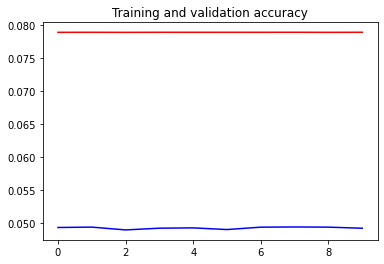

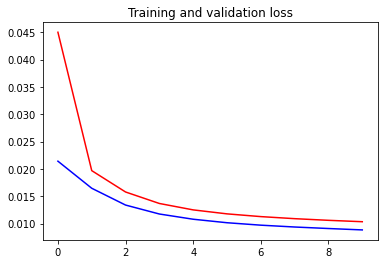

In [12]:
trHist = np.array([h.history['acc'],
                   h.history['val_acc'], 
                   h.history['loss'],
                   h.history['val_loss']])

epochs = range(len(trHist[0])) # Get list of numbers in length of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs[0:100], trHist[0], 'r', label = "Training Accuracy")
plt.plot(epochs[0:100], trHist[1], 'b',label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs[0:100], trHist[2], 'r', label = "Training Loss")
plt.plot(epochs[0:100], trHist[3], 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.show()

In [13]:
!ls ../../Datasets/DVRUP_1f_UINT8_82020/

Hagen1DUINT8X.npy  Hytta1DUINT8X.npy  Skogen1DUINT8X.npy  Skogen5DUINT8X.npy
Hagen1DUINT8Y.npy  Hytta1DUINT8Y.npy  Skogen1DUINT8Y.npy  Skogen5DUINT8Y.npy
Hagen2DUINT8X.npy  Hytta2DUINT8X.npy  Skogen2DUINT8X.npy  Skogen6DUINT8X.npy
Hagen2DUINT8Y.npy  Hytta2DUINT8Y.npy  Skogen2DUINT8Y.npy  Skogen6DUINT8Y.npy
Hagen3DUINT8X.npy  Hytta3DUINT8X.npy  Skogen3DUINT8X.npy  Skogen7DUINT8X.npy
Hagen3DUINT8Y.npy  Hytta3DUINT8Y.npy  Skogen3DUINT8Y.npy  Skogen7DUINT8Y.npy
Hagen4DUINT8X.npy  Hytta4DUINT8X.npy  Skogen4DUINT8X.npy
Hagen4DUINT8Y.npy  Hytta4DUINT8Y.npy  Skogen4DUINT8Y.npy


In [22]:
#Load dataset, reshape and predict some test images!
def loadDataset(file, dir = "./datasetDir/"):
    X = np.load(dir + file +"DUINT8X.npy")[:, :, :, :]
    Y = np.load(dir + file +"DUINT8Y.npy")[:, :, :, :]
    return X, Y

vX, vY = loadDataset('Skogen7', dir = '../../Datasets/DVRUP_1f_UINT8_82020/')
vX = vX.astype(float)/255.0
vY = vY.astype(float)/255.0

In [23]:
#Reshaping the x dataset
def getFramesAround(DS, num, fbf = 2, faf = 1):
    """ Returns a matrix with the fbf frames before and the faf frames after frame number num """
    return np.stack(DS[(num-fbf):(1+num+faf)], axis = 3)

def reshapeDStoFBF(X, Y, fbf = 2, faf = 1):
    """ Reshapes the dataset so that each entry contains the fbf frames before and faf frames after the entry """
    rn = fbf
    buf =  np.empty((len(X) - (faf + fbf), len(X[0]), len(X[0][0]),chan, frames), np.dtype('uint8'))
    for i in range(len(X) - (faf + fbf)):
        buf[rn - fbf] = getFramesAround(X, rn,fbf,faf)
        rn += 1
    print('Reshaped dataset to size: ', buf.shape)
    return buf

def normalizeDS(x):
    x = x - x.mean()
    x = x * x.std()
    return x

nX = reshapeDStoFBF(vX, vY, framesBefore, framesAfter)
print('New shapes: x:', nX.shape, 'y', vY.shape)
#Swapping the axes
nX = np.swapaxes(nX, 3, 4)

#nX = nX - nX.mean()
#nX = nX * nX.std()

Reshaped dataset to size:  (995, 360, 640, 3, 4)
New shapes: x: (995, 360, 640, 3, 4) y (998, 360, 640, 3)


In [24]:
def showFrame(frame, title = 'Frame', show = True):
    plt.imshow(frame)
    plt.title(title)
    if show:
        plt.show()

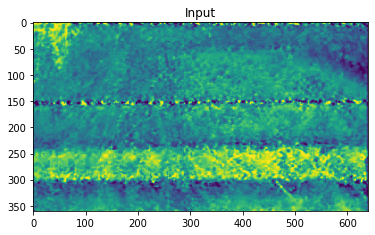

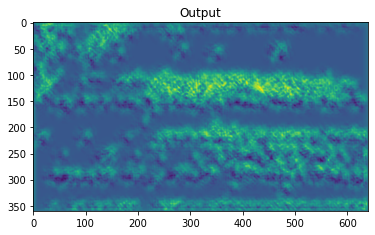

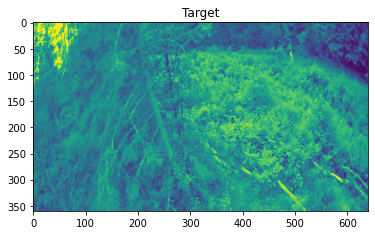

Experimenting with augmentation use


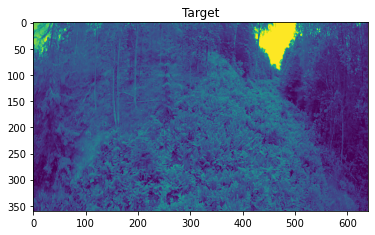

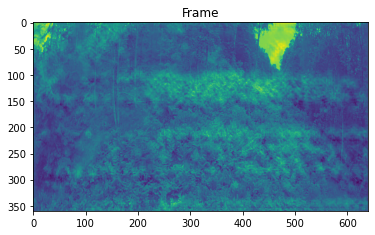

In [40]:
#Predicting one frame and showing it
f = 50
valFrame = np.clip(autoencoder.predict(nX[f:f+1, :, :, :, 0], batch_size = batch_size), -1.0, 1.0)
showFrame(vX[f, :, :, 0], title = 'Input')
showFrame(valFrame[0, :, :], title = 'Output')
#showFrame(valFrame[0, :, :, 0])
#showFrame(valFrame[0, :, :, 1])
#showFrame(valFrame[0, :, :, 2])
#showFrame(valFrame[0, :, :, :])
showFrame(vY[f, :, :, 0], title = 'Target')

print('Experimenting with augmentation use')
f2 = 100
showFrame(vY[f2, :, :, 0], title = 'Target')
showFrame(vY[f2, :, :, 0] + valFrame[0, : ,:, 0])

In [26]:
print('Processed: ')
print('Max: ', valFrame[0].max(), 'Min:', valFrame[0].min(),' mean: ', valFrame[0].mean())
print('Input: ')
print('Max: ', vX[f, :, :, 0].max(), 'Min:', vX[f, :, :, 0].min(),' mean: ', vX[f, :, :, 0].mean())
print('Output: ')
print('Max: ', vY[f, :, :, 0].max(), 'Min:', vY[f, :, :, 0].min(),' mean: ', vY[f, :, :, 0].mean())

Processed: 
Max:  0.5757782 Min: -0.22463302  mean:  0.07529774
Input: 
Max:  1.0 Min: 0.0  mean:  0.510004476443355
Output: 
Max:  0.996078431372549 Min: 0.0  mean:  0.4829345213779957


In [ ]:
#%tensorboard --logdir log_dir

In [27]:
outN = '81'
lpath = '../TrainingResults/lossAndAcc/'
spath = '../TrainingResults/stats/'
np.save(lpath + outN + 'l', trHist)
a = np.array([startTime, 
              initComment, 
              datasetSize, 
              datasetsToLoad, 
              framesSkipped,
              (nx, ny), 
              framesBefore, 
              framesAfter, 
              baseConvLay, 
              usedLoss, 
              epochs,
              trHist[3][-1],
              trHist[1][-1],
              'cyberspace - RTX3090',
              ' ~ < 0.5h ',
              ' Model might be useful for augmentation '], dtype = object)
np.save(spath + outN +'c', a)
print(a)

[datetime.datetime(2021, 4, 6, 9, 0, 49, 449652)
 ' Experimenting with dataset variation. Same input and output, unnormalized '
 0
 list(['../../Datasets/DVRUP_Pre_NoNorm/Skogen1.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Skogen2.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Skogen3.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Skogen4.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Skogen5.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Skogen6.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Hagen1.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Hagen2.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Hagen3.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Hagen4.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Hytta1.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Hytta2.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Hytta3.tfrec', '../../Datasets/DVRUP_Pre_NoNorm/Hytta4.tfrec'])
 5 (640, 360) 2 1 32 ' MSE ' range(0, 10) 0.008850181475281715
 0.0491887591779232 'cyberspace - RTX3090' ' ~ < 0.5h '
 ' Model might be useful for augmentation ']


In [28]:
modPath = '../Models/'
autoencoder.save(modPath + outN +'.h5')

In [29]:
print(' Experiment',  outN, 'executed using tensorflow V', tf.__version__)

 Experiment 81 executed using tensorflow V 2.5.0-dev20210223
